In [58]:
# для PSI CSI
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Dataset Прогнозирует наличие диабета по медицинским показателям
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
        "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
df = pd.read_csv(url, names=cols)

df.head()



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


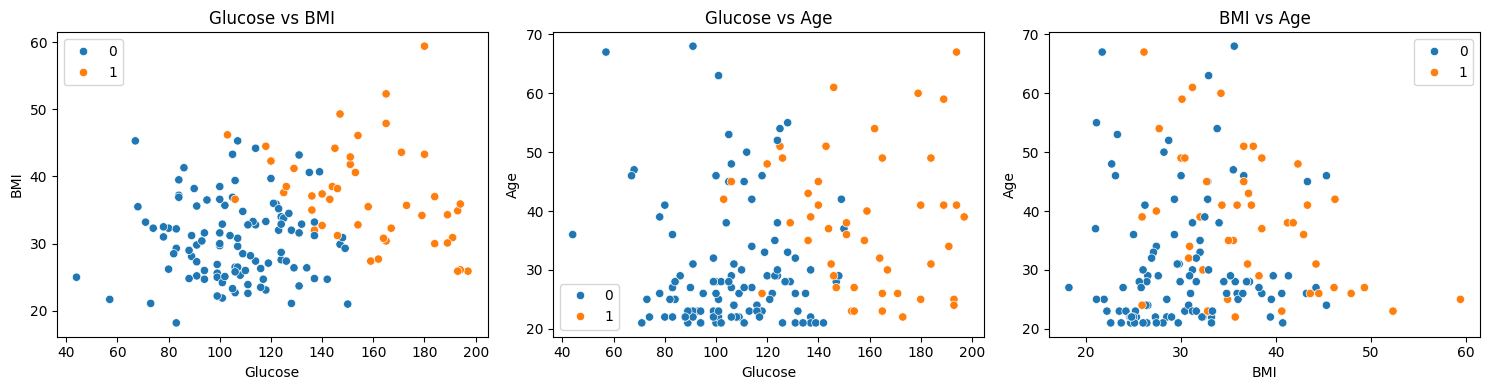

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.81      0.78       100
           1       0.59      0.50      0.54        54

    accuracy                           0.70       154
   macro avg       0.67      0.66      0.66       154
weighted avg       0.69      0.70      0.70       154

Confusion Matrix:
[[81 19]
 [27 27]]


In [59]:
features_to_check = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[features_to_check] = df[features_to_check].replace(0, np.nan)

# Заполним пропуски медианой
df.fillna(df.median(), inplace=True)


X = df.drop(columns = "Outcome", axis=1)
y = df["Outcome"]


# Разделение на "train" и "test"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 5. Модель логистической регрессии
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


# Предсказания вероятностей
y_pred=model.predict(X_test)
y_proba=model.predict_proba(X_test)

x1 = X_test["Glucose"]
x2 = X_test["BMI"]
x3 = X_test["Age"]

# Построение графиков
plt.figure(figsize=(15, 4))

ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

sns.scatterplot(x=x1, y=x2, hue=y_pred, ax=ax1)
ax1.set_title("Glucose vs BMI")

sns.scatterplot(x=x1, y=x3, hue=y_pred, ax=ax2)
ax2.set_title("Glucose vs Age")

sns.scatterplot(x=x2, y=x3, hue=y_pred, ax=ax3)
ax3.set_title("BMI vs Age")

plt.tight_layout()
plt.show()

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

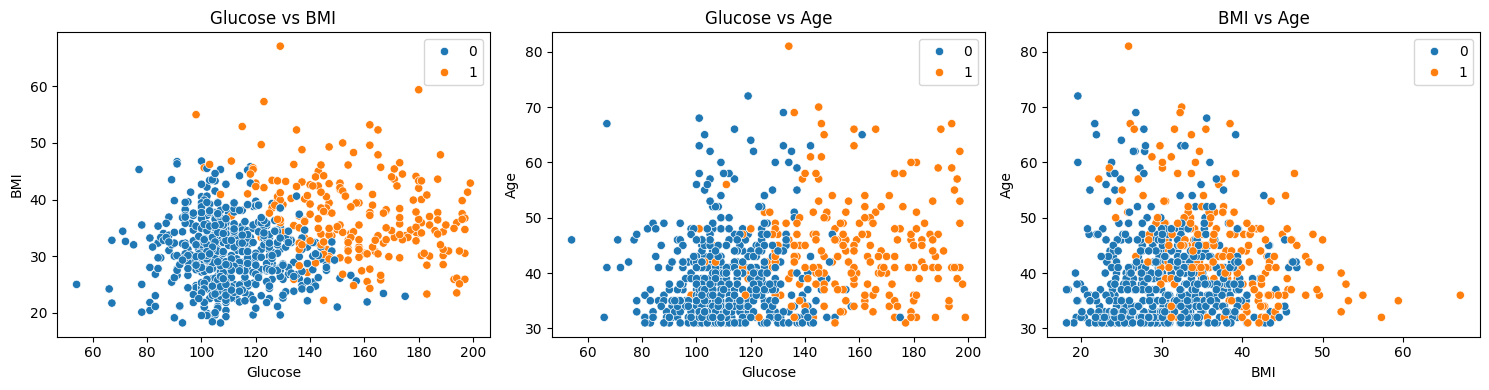

In [60]:
# Создаем выборку New
df_new = df.copy()
df_new['Glucose'] = df_new['Glucose'].apply(lambda x: x+10 if x<100 else x)
df_new['Age'] = df_new['Age'].apply(lambda x:x+10 if x<40 else x)
Z = df_new.drop(columns = "Outcome", axis=1)

z_pred = model.predict(Z)
z_proba = model.predict_proba(Z)

z1 = Z["Glucose"]
z2 = Z["BMI"]
z3 = Z["Age"]

# Построение графиков
plt.figure(figsize=(15, 4))

ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

sns.scatterplot(x=z1, y=z2, hue=z_pred, ax=ax1)
ax1.set_title("Glucose vs BMI")

sns.scatterplot(x=z1, y=z3, hue=z_pred, ax=ax2)
ax2.set_title("Glucose vs Age")

sns.scatterplot(x=z2, y=z3, hue=z_pred, ax=ax3)
ax3.set_title("BMI vs Age")

plt.tight_layout()
plt.show()

In [61]:
# PSI
def psi(score_initial, score_new, num_bins = 10, mode = 'fixed'):

    eps = 1e-4

    # Sort the data
    score_initial.sort()
    score_new.sort()

    # Prepare the bins
    min_val = min(min(score_initial), min(score_new))
    max_val = max(max(score_initial), max(score_new))
    if mode == 'fixed':
        bins = [min_val + (max_val - min_val)*(i)/num_bins for i in range(num_bins+1)]
    elif mode == 'quantile':
        bins = pd.qcut(score_initial, q = num_bins, retbins = True, duplicates='drop')[1] # Create the quantiles based on the initial population
        num_bins = len(bins) - 1  # обновим количество бинов после удаления дубликатов
    else:
        raise ValueError(f"Mode \'{mode}\' not recognized. Your options are \'fixed\' and \'quantile\'")
    bins[0] = min_val - eps # Correct the lower boundary
    bins[-1] = max_val + eps # Correct the higher boundary


    # Bucketize the initial population and count the sample inside each bucket
    bins_initial = pd.cut(score_initial, bins = bins, labels = range(1,num_bins+1))
    df_initial = pd.DataFrame({'initial': score_initial, 'bin': bins_initial})
    grp_initial = df_initial.groupby('bin', observed=True).count()
    grp_initial['percent_initial'] = grp_initial['initial'] / sum(grp_initial['initial'])

    # Bucketize the new population and count the sample inside each bucket
    bins_new = pd.cut(score_new, bins = bins, labels = range(1,num_bins+1))
    df_new = pd.DataFrame({'new': score_new, 'bin': bins_new})
    grp_new = df_new.groupby('bin', observed=True).count()
    grp_new['percent_new'] = grp_new['new'] / sum(grp_new['new'])

    # Compare the bins to calculate PSI
    psi_df = grp_initial.join(grp_new, on = "bin", how = "inner")

    # Add a small value for when the percent is zero
    psi_df['percent_initial'] = psi_df['percent_initial'].apply(lambda x: eps if x == 0 else x)
    psi_df['percent_new'] = psi_df['percent_new'].apply(lambda x: eps if x == 0 else x)

    # Calculate the psi
    psi_df['psi'] = (psi_df['percent_initial'] - psi_df['percent_new']) * np.log(psi_df['percent_initial'] / psi_df['percent_new'])

    # Return the psi values
    return psi_df['psi'].values

In [62]:
psi_values_fixed = psi(y_proba[:,1], z_proba[:,1], mode = 'fixed')
print(np.mean(psi_values_fixed))
np.mean(psi_values_fixed)

0.008434656294316004


np.float64(0.008434656294316004)

In [63]:
psi_values_quantile = psi(y_proba[:,1], z_proba[:,1], mode = 'quantile')
print(np.mean(psi_values_quantile))
np.mean(psi_values_quantile)

0.01193458687564298


np.float64(0.01193458687564298)

In [64]:
# CSI classification
# Сoхранение данных для расчетов CSI
df_test = X_test.copy()
df_test['y'] = y_test
df_test['pred'] = y_pred
df_test['proba'] = y_proba[:,1]
C=Z.copy()
C['pred'] = z_pred
C['proba'] = z_proba[:,1]

df_test.head()

C.head()

sample_initial = df_test[["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
        "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]]
sample_new = C[["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
        "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]]
# Fixed
for col in sample_initial.columns:
    csi_values = psi(sample_initial[col].values, sample_new[col].values, num_bins = 10, mode = 'fixed')
    csi = np.mean(csi_values)
    print(f'{col} -> {csi=:.4f}')

Pregnancies -> csi=0.0027
Glucose -> csi=0.0169
BloodPressure -> csi=0.0054
SkinThickness -> csi=0.0026
Insulin -> csi=0.0075
BMI -> csi=0.0035
DiabetesPedigreeFunction -> csi=0.0041
Age -> csi=0.0531


In [65]:
# Quantile
for col in sample_initial.columns:
    csi_values = psi(sample_initial[col].values, sample_new[col].values, num_bins = 10, mode = 'quantile')
    csi = np.mean(csi_values)
    print(f'{col} -> {csi=:.4f}')

Pregnancies -> csi=0.0028
Glucose -> csi=0.0193
BloodPressure -> csi=0.0085
SkinThickness -> csi=0.0020
Insulin -> csi=0.0113
BMI -> csi=0.0060
DiabetesPedigreeFunction -> csi=0.0023
Age -> csi=0.1064
